In [277]:
# !pip install implicit rectools lightfm

In [314]:
#  !pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.0 MB/s eta 0:00:00


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [278]:
!pip install implicit==0.7.2 requests==2.32.3 rectools[lightfm]==0.12.0 pandas==2.2.3 numpy==1.26.4 scipy==1.12.0

In [279]:
import pandas as pd
import requests
from tqdm.auto import tqdm
from pprint import pprint
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender
import warnings

from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.metrics import MAP, calc_metrics
from rectools.model_selection import TimeRangeSplitter
from rectools.models import PopularModel, RandomModel, ImplicitItemKNNWrapperModel, PopularInCategoryModel,EASEModel,ImplicitALSWrapperModel, ImplicitBPRWrapperModel,LightFMWrapperModel
from rectools.model_selection import TimeRangeSplitter
from rectools.dataset import Dataset
from rectools.metrics import MeanInvUserFreq, AvgRecPopularity
from implicit.bpr import BayesianPersonalizedRanking
from lightfm import LightFM

from implicit.als import AlternatingLeastSquares


In [280]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='Downloading the kion dataset...',
                        total=total_size_in_bytes,
                        unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [281]:
# !unzip kion_train.zip -x '__MACOSX/*'

Archive:  kion_train.zip
replace data_original/interactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [282]:
interactions = (
    pd.read_csv('data_original/interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={'total_dur': Columns.Weight,
                     'last_watch_dt': Columns.Datetime})
)
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

### ! если хотите быстро прогнать этот ноутбук - раскомментируйте эти строки - она уменьшает данные
import numpy as np
user_ids = np.random.choice(interactions.user_id.unique(), size=50000, replace=False)
interactions = interactions[interactions.user_id.isin(user_ids)]
###

print(interactions.shape, interactions.user_id.nunique())
interactions.head()

(282683, 5) 50000


,user_id,item_id,datetime,weight,watched_pct
2,656683,7107,2021-05-09,10,0.0
18,927973,9617,2021-06-19,8422,100.0
24,916352,12846,2021-08-12,1812,30.0
41,985101,4566,2021-07-16,420,34.0
53,35423,5648,2021-06-10,52,1.0


In [283]:
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


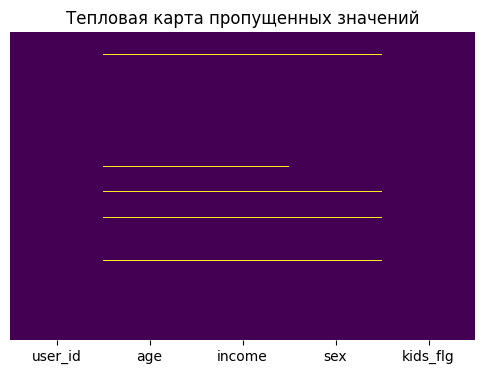

In [284]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(users.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [285]:
missing_percentage_users = users.isnull().mean() * 100

# Форматируем вывод
print("Процент пропущенных значений в каждой колонке:")
print(missing_percentage_users)

Процент пропущенных значений в каждой колонке:
user_id     0.000000
age         1.677583
income      1.758635
sex         1.646162
kids_flg    0.000000
dtype: float64


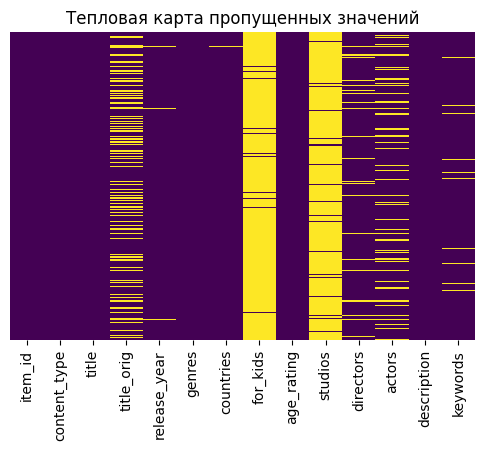

In [286]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(items.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [287]:
missing_percentage_items = items.isnull().mean() * 100

# Форматируем вывод
print("Процент пропущенных значений в каждой колонке:")
print(missing_percentage_items)

Процент пропущенных значений в каждой колонке:
item_id          0.000000
content_type     0.000000
title            0.000000
title_orig      29.724989
release_year     0.613920
genres           0.000000
countries        0.231786
for_kids        96.454301
age_rating       0.012529
studios         93.328322
directors        9.453110
actors          16.406690
description      0.012529
keywords         2.649878
dtype: float64


In [288]:
interactions.shape,items.shape,users.shape

((282683, 5), (15963, 14), (840197, 5))

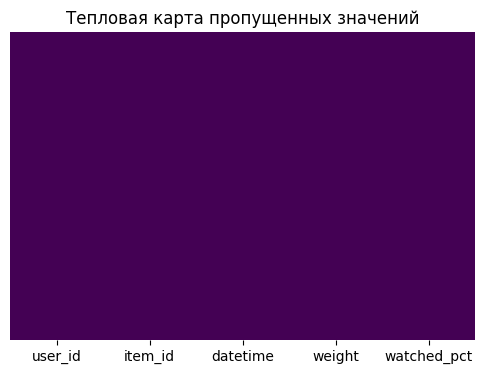

In [289]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(interactions.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [290]:
# 1) Привести колонку к datetime (обязательно, если там строки)
interactions['datetime'] = pd.to_datetime(interactions['datetime'], errors='coerce')
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] <= max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['datetime'] > max_date - pd.Timedelta(days=7))]

# оставляем только теплых пользователей в тесте
test = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (261441, 5)
test: (15360, 5)


In [291]:
from rectools.dataset import Dataset

interactions_dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)

In [292]:
# 1. Создаем PopularModel
pop_model = PopularModel(popularity='n_interactions') #popularity='n_interactions'
pop_model.fit(interactions_dataset)

In [293]:
# Предсказание топ 5 предметов для пользователя
user_id = [1]  # Пример ID пользователя
popular_items = pop_model.recommend(user_id, interactions_dataset,filter_viewed=False, k=10)
popular_items

,user_id,item_id,score,rank
0,1,10440,9830.0,1
1,1,15297,9337.0,2
2,1,9728,6162.0,3
3,1,13865,6044.0,4
4,1,4151,4478.0,5
5,1,3734,3651.0,6
6,1,2657,3378.0,7
7,1,4880,2812.0,8
8,1,142,2230.0,9
9,1,6809,2024.0,10


In [294]:
# Найти предметы с наибольшим score
# Сначала отсортируем по колонке 'score' в порядке убывания
highest_scored_items = popular_items.sort_values(by="score", ascending=False)

# Выведем предметы с максимальным score (весь список или, например, топ-1)
top_item = highest_scored_items.head(10)  # Для случая, когда нужен только один самый лучший предмет
print("Товар с наивысшим score:\n", top_item)

Товар с наивысшим score:
    user_id  item_id   score  rank
0        1    10440  9830.0     1
1        1    15297  9337.0     2
2        1     9728  6162.0     3
3        1    13865  6044.0     4
4        1     4151  4478.0     5
5        1     3734  3651.0     6
6        1     2657  3378.0     7
7        1     4880  2812.0     8
8        1      142  2230.0     9
9        1     6809  2024.0    10


In [295]:
pop_recs_1 = popular_items.merge(items[['item_id', 'title']],
                           on='item_id',
                           how='left')
pop_recs_1

,user_id,item_id,score,rank,title
0,1,10440,9830.0,1,Хрустальный
1,1,15297,9337.0,2,Клиника счастья
2,1,9728,6162.0,3,Гнев человеческий
3,1,13865,6044.0,4,Девятаев
4,1,4151,4478.0,5,Секреты семейной жизни
5,1,3734,3651.0,6,Прабабушка легкого поведения
6,1,2657,3378.0,7,Подслушано
7,1,4880,2812.0,8,Афера
8,1,142,2230.0,9,Маша
9,1,6809,2024.0,10,Дуров


In [296]:
pop_recs = pop_model.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

pop_recs = pop_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
pop_recs.head(10)

,user_id,item_id,score,rank,title
0,734550,10440,9830.0,1,Хрустальный
1,734550,15297,9337.0,2,Клиника счастья
2,734550,9728,6162.0,3,Гнев человеческий
3,734550,13865,6044.0,4,Девятаев
4,734550,4151,4478.0,5,Секреты семейной жизни
5,734550,3734,3651.0,6,Прабабушка легкого поведения
6,734550,2657,3378.0,7,Подслушано
7,734550,4880,2812.0,8,Афера
8,734550,142,2230.0,9,Маша
9,734550,6809,2024.0,10,Дуров


In [297]:
# популярность признаку genres
# items["genre"] = items["genres"].str.split(",")
items["genre"] = items["genres"].str.lower().str.split(r"\s*,\s*")
items[["genre", "genres","item_id"]].head()

,genre,genres,item_id
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы",10711
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии",2508
2,"[криминал, зарубежные, триллеры, боевики, коме...","криминал, зарубежные, триллеры, боевики, комедии",10716
3,"[драмы, зарубежные, мелодрамы]","драмы, зарубежные, мелодрамы",7868
4,"[драмы, спорт, советские, мелодрамы]","драмы, спорт, советские, мелодрамы",16268


In [298]:
# делаем flatten представление фичи жанров
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [299]:
cc = genre_feature['value'].value_counts()
small_genres = cc[cc <= 50].index  # можно без .tolist()
genre_feature.loc[genre_feature['value'].isin(small_genres), 'value'] = 'other'
len(small_genres)

46

In [300]:
genre_feature[genre_feature['value']=='other']

,id,value,feature
12,4778,other,genre
19,15261,other,genre
70,4547,other,genre
87,1314,other,genre
87,1314,other,genre
...,...,...,...
15859,4902,other,genre
15894,12765,other,genre
15896,15557,other,genre
15914,5870,other,genre


In [301]:
genre_feature = genre_feature[genre_feature['id'].isin(train['item_id'])]
genre_feature

,id,value,feature
7,11114,для детей,genre
7,11114,сказки,genre
7,11114,полнометражные,genre
7,11114,зарубежные,genre
7,11114,семейное,genre
...,...,...,...
15959,2367,драмы,genre
15959,2367,боевики,genre
15961,4538,драмы,genre
15961,4538,спорт,genre


In [373]:
# Process item features to the form of a flatten dataframe
cols = ['item_id','genres','content_type','title','countries','age_rating']

# Если нужно заменить и пустые строки/пробелы:
items_diff = items[cols].replace(r'^\s*$', np.nan, regex=True).fillna('unknown')
items_diff
items_train = items_diff.loc[items_diff[Columns.Item].isin(train[Columns.Item])].copy()
def prepare_item_features(item_features):
    """
    Подготовка фичей items в формате как нужно rectools
    """
    new_df = pd.DataFrame()
    items = item_features.copy()

    genres = items[['genres','item_id']].copy()
    genres['genres'] = genres['genres'].str.replace(' +','',regex=True).str.split(',')
    genres = genres.explode('genres')
    # небольшая предобработка похожих жанров
    genres['genres'] = genres['genres'].replace({'советские':'русские','единоборства':'спорт','мультфильмы':'мультфильм',
                                                 'фильм-нуар':'детективы','фитнес':'спорт','историческое':'исторические',
                                                 'западныемультфильмы':'мультфильм','мультсериалы':'мультфильм','воспитаниедетей':'развитие',
                                                 'русскиемультфильмы':'мультфильм','18+':'длявзрослых','анимация':'мультфильм',
                                                'покомиксам':'фантастика'})
    cc = genres['genres'].value_counts(normalize=True)

    # если жанк редкий и встречается менее чем в 5% items - заполним их тэгом other
    small_genres = cc[cc <= 0.05].index.tolist()
    genres.loc[genres['genres'].isin(cc),'genres'] = 'other'
    genres.drop_duplicates(inplace=True)
    genres['feature'] = 'genre'
    genres['weight'] = 1
    new_df = pd.concat([new_df,genres.rename(columns={'genres':'value'})],ignore_index=True)

    ages = items[['item_id','age_rating']].rename(columns={'age_rating':'value'}).copy()
    ages['feature'] = 'age_rating'
    ages['weight'] = 1
    new_df = pd.concat([new_df,ages],ignore_index=True)

    ages = items[['item_id','content_type']].rename(columns={'content_type':'value'}).copy()
    ages['feature'] = 'content_type'
    ages['weight'] = 1
    new_df = pd.concat([new_df,ages],ignore_index=True)

    countries = items[['countries','item_id']].copy()
    countries['countries'] = countries['countries'].str.replace(' +','',regex=True).str.split(',')
    countries = countries.explode('countries')
    # небольшая предобработка похожих стран
    countries['countries'] = countries['countries'].replace({'СССР':'Россия'})
    cc = countries['countries'].value_counts(normalize=True)

    # если эта страна редкая и встречается менее чем в 5% items - заполним их тэгом other
    small_countries = cc[cc <= 0.05].index.tolist()
    countries.loc[countries['countries'].isin(cc),'countries'] = 'other'
    countries.drop_duplicates(inplace=True)
    countries['feature'] = 'countries'
    countries['weight'] = 1
    new_df = pd.concat([new_df,countries.rename(columns={'countries':'value'})],ignore_index=True)

    return new_df.rename(columns={'item_id':'id'})
item_features_train = prepare_item_features(items_train)
item_features_train

,value,id,feature,weight
0,длядетей,11114,genre,1
1,сказки,11114,genre,1
2,полнометражные,11114,genre,1
3,зарубежные,11114,genre,1
4,семейное,11114,genre,1
...,...,...,...,...
45761,Россия,15610,countries,1
45762,Финляндия,6443,countries,1
45763,Германия,6443,countries,1
45764,Россия,2367,countries,1


In [372]:
# Process item features to the form of a flatten dataframe
cols = ['user_id',"age","sex","kids_flg"]

# Если нужно заменить и пустые строки/пробелы:
users_diff = users[cols].replace(r'^\s*$', np.nan, regex=True).fillna('unknown')

user_train = users_diff.loc[users_diff[Columns.User].isin(train[Columns.User])].copy()
def prepare_user_features(users,cols=["age","sex","kids_flg"]):
    """
    Подготовка фичей пользователей в формате как нужно rectools
    """
    new_df = pd.DataFrame(columns=["feature","value","weight"])
    for col in cols:
        tr_df = users[[col,"user_id"]].copy()
        tr_df.rename(columns={col:"value","user_id":"id"},inplace=True)
        tr_df['weight'] = 1
        tr_df['feature'] = col
        new_df = pd.concat([new_df,tr_df],ignore_index=True)
        new_df['id'] =  new_df['id'].astype(int)
    return new_df
user_features_train=prepare_user_features(user_train)
user_features_train

,feature,value,weight,id
0,age,age_45_54,1,721985
1,age,age_35_44,1,269408
2,age,age_25_34,1,1024113
3,age,age_35_44,1,505245
4,age,age_35_44,1,552438
...,...,...,...,...
109705,kids_flg,0,1,476507
109706,kids_flg,0,1,507833
109707,kids_flg,0,1,641933
109708,kids_flg,0,1,848247


In [365]:
# user_features_train[user_features_train['id']==721985]

In [366]:
# users[users['user_id']==721985]

In [363]:
# # pip install gensim
# import numpy as np
# import pandas as pd
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess

# # 1) Токенизация: превращаем список строк в список токенов
# def cell_to_tokens(cell):
#     # cell — список строк или NaN/None/строка
#     if cell is None or (isinstance(cell, float) and pd.isna(cell)):
#         return []
#     if isinstance(cell, list):
#         # каждую строку разбиваем на слова, приводим к нижнему регистру, убираем пунктуацию
#         tokens = []
#         for s in cell:
#             tokens.extend(simple_preprocess(str(s), deacc=True))  # deacc=True убирает знаки препинания
#         return tokens
#     # иногда может быть строка вместо списка
#     return simple_preprocess(str(cell), deacc=True)

# # 2) Собираем корпус "предложений" для обучения W2V
# list_cols = ['actors', 'description', 'keywords']
# sentences = []
# for c in list_cols:
#     sentences.extend(items_diff[c].apply(cell_to_tokens).tolist())

# # удалим пустые предложения
# sentences = [s for s in sentences if len(s) > 0]
# print('gg')
# # 3) Обучаем Word2Vec на вашем корпусе
# # Параметры можно подстроить: vector_size, window, min_count, sg (1=skip-gram, 0=CBOW)
# w2v = Word2Vec(
#     sentences=sentences,
#     vector_size=300,
#     window=5,
#     min_count=2,
#     workers=4,
#     sg=1,
#     epochs=1,

# )

# # 4) Функция кодирования одной ячейки: среднее по векторам известных токенов
# def encode_cell_avg(cell):
#     toks = cell_to_tokens(cell)
#     vecs = [w2v.wv[t] for t in toks if t in w2v.wv.key_to_index]
#     if vecs:
#         return np.mean(vecs, axis=0).astype(np.float32)
#     # если ни одного токена нет в словаре — вернём нулевой вектор
#     return np.zeros(w2v.vector_size, dtype=np.float32)

# # 5) Применяем к нужным столбцам
# items_diff['actors_w2v']      = items_diff['actors'].apply(encode_cell_avg)
# items_diff['description_w2v'] = items_diff['description'].apply(encode_cell_avg)
# items_diff['keywords_w2v']    = items_diff['keywords'].apply(encode_cell_avg)

# # Пример проверки размеров вектора:
# print(items_diff['actors_w2v'].iloc[0].shape)  # (300,)

In [367]:
dataset_feature_pop = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre']
)

In [368]:
dataset_feature_light_FM = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre'],
    make_dense_user_features=False
)

In [378]:
dataset_feature_light_FM_all_features = Dataset.construct(
    interactions_df=train,
    user_features_df= user_features_train,
    item_features_df=item_features_train,
    cat_user_features=['age', 'sex', 'kids_flg'],
    cat_item_features=['genre', 'age_rating', 'content_type', 'countries'],
    make_dense_user_features=False
)

In [ ]:
from rectools.models.popular_in_category import PopularInCategoryModel

pop_cat = PopularInCategoryModel(category_feature='genre', n_categories=5)
pop_cat.fit(dataset_feature_pop);

In [ ]:
pop_recs_cat = pop_cat.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_pop,
    k=10,
    filter_viewed=False
)

In [ ]:
pop_recs_cat = pop_recs_cat.merge(items[['item_id', 'title']],
                                   on='item_id',
                                   how='left')

pop_recs_cat.head(10)

In [ ]:
# model_ease = EASEModel(regularization=500)
# model_ease.fit(interactions_dataset);

In [ ]:
# ease_recs = model_ease.recommend(
#     test.user_id.unique(),
#     dataset=interactions_dataset,
#     k=10,
#     filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
# )

# ease_recs = ease_recs.merge(items[['item_id', 'title']],
#                                on='item_id',
#                                how='left')
# ease_recs.head(10)

In [ ]:
model_iALS = ImplicitALSWrapperModel(
    AlternatingLeastSquares(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    ),
    fit_features_together=False,  # way to fit paired features
)
model_iALS.fit(interactions_dataset);

In [ ]:
model_iALS.get_config()

In [ ]:
iALS_recs = model_iALS.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs = iALS_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs.head(10)

In [ ]:
model_iALS_Bpr = ImplicitBPRWrapperModel(
     BayesianPersonalizedRanking(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        # alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    )
    # fit_features_together=False,  # way to fit paired features
)
model_iALS_Bpr.fit(interactions_dataset);

In [ ]:
iALS_recs_BPR = model_iALS_Bpr.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs_BPR  = iALS_recs_BPR.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs_BPR.head(10)

In [ ]:
model_LightFM = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
    )

)
model_LightFM.fit(interactions_dataset);

In [ ]:
LightFM_recs= model_LightFM.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

LightFM_recs = LightFM_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
LightFM_recs.head(10)

In [ ]:
model_LightFM_features = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
    )

)
model_LightFM_features.fit(dataset_feature_light_FM);

In [ ]:
LightFM_recs_features= model_LightFM_features.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_light_FM,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

LightFM_recs_features = LightFM_recs_features.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
LightFM_recs_features.head(10)

In [ ]:
dataset_feature_light_FM_all_features

In [382]:
model_LightFM_features_all = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
    )

)
model_LightFM_features_all.fit(dataset_feature_light_FM_all_features);

In [383]:
LightFM_recs_features_all= model_LightFM_features_all.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_light_FM_all_features,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

LightFM_recs_features_all = LightFM_recs_features_all.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
LightFM_recs_features_all.head(10)

,user_id,item_id,score,rank,title
0,734550,15297,-66.085548,1,Клиника счастья
1,734550,9728,-66.169785,2,Гнев человеческий
2,734550,10440,-66.170746,3,Хрустальный
3,734550,13865,-66.396019,4,Девятаев
4,734550,3734,-66.902000,5,Прабабушка легкого поведения
5,734550,4151,-66.961578,6,Секреты семейной жизни
6,734550,142,-67.093201,7,Маша
7,734550,2657,-67.113098,8,Подслушано
8,734550,9996,-67.170403,9,Немцы
9,734550,4880,-67.245827,10,Афера


In [388]:
model_ilas_BPR_features_all = ImplicitBPRWrapperModel(
     BayesianPersonalizedRanking(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        # alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    )
    # fit_features_together=False,  # way to fit paired features
)
model_ilas_BPR_features_all.fit(dataset_feature_light_FM_all_features)

In [389]:
iALS_recs_BPR_features_all = model_ilas_BPR_features_all.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_light_FM_all_features,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs_BPR_features_all  = iALS_recs_BPR_features_all.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs_BPR_features_all.head(10)

,user_id,item_id,score,rank,title
0,734550,15297,0.246748,1,Клиника счастья
1,734550,9728,0.196401,2,Гнев человеческий
2,734550,10440,0.194442,3,Хрустальный
3,734550,3734,0.192234,4,Прабабушка легкого поведения
4,734550,3289,0.166419,5,Распрекрасный принц
5,734550,13055,0.164542,6,Влюбиться в Сун-чжон
6,734550,2356,0.159216,7,Артур и война двух миров
7,734550,13586,0.155902,8,Три богатыря. Принцесса Египта
8,734550,8066,0.150485,9,Штетл
9,734550,4797,0.148100,10,Тихое место 2


In [390]:
from rectools.metrics import (calc_metrics, MeanInvUserFreq,
                              AvgRecPopularity, MAP, NDCG, CoveredUsers,HitRate,
                              CatalogCoverage,Intersection,Serendipity)

recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    # "ease_recs": ease_recs,
    'iALS_recs':iALS_recs,
    'iALS_recs_BPR': iALS_recs_BPR,
    'LightFM_recs':LightFM_recs,
    'LightFM_recs_features':LightFM_recs_features,
    'LightFM_recs_features_all':LightFM_recs_features_all,
    'iALS_recs_BPR_features_all':iALS_recs_BPR_features_all
}

metrics= {
    'map@10': MAP(k=10), # качество ранжирования
    "novelty": MeanInvUserFreq(k=10), # глобальная новизна
    "arp": AvgRecPopularity(k=10),  # popularity bias
    "ndcg": NDCG(k=10),
    "covarege": CoveredUsers(k=10),
    "hitrate": HitRate(k=10),
    "Intersection":Intersection(k=10),
    "Serendipity@10": Serendipity(k=10)

}

metrics_dict = {}
for model_name, recs_1 in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs_1,
        interactions=test,
        prev_interactions=train,
        catalog=train['user_id'].unique(),
        # ref_reco=["popular"]
        ref_reco = {"same_model": recs_1}
    )


pd.DataFrame(metrics_dict).T

,hitrate,ndcg,map@10,novelty,arp,Serendipity@10,Intersection_same_model,covarege
pop,0.247069,0.034982,0.066347,3.440637,4994.600000,0.000000e+00,1.0,1.000000
pop_cat,0.015223,0.002244,0.004639,4.327648,3311.900000,1.230284e-07,1.0,0.055293
iALS_recs,0.001750,0.000171,0.000330,9.871705,248.103054,2.838287e-07,1.0,0.055293
iALS_recs_BPR,0.014523,0.002029,0.003715,5.180459,3733.926251,2.323870e-07,1.0,0.055293
LightFM_recs,0.017323,0.002381,0.004379,3.450812,4980.701646,1.007250e-08,1.0,0.055293
LightFM_recs_features,0.016273,0.002184,0.003728,3.955719,4413.016647,7.194643e-08,1.0,0.055293
LightFM_recs_features_all,0.254243,0.035571,0.067280,3.941537,4399.793106,2.702643e-06,1.0,1.000000
iALS_recs_BPR_features_all,0.173928,0.028296,0.060167,7.910418,2910.459685,1.162515e-06,1.0,1.000000


In [392]:
def leave_top_k(reco, k):
    # Функция для выбора топ-K рекомендаций
    return reco[reco['rank'] <= k]

def coverage(reco, k, interactions, catalog):


    # Оставляем только топ-K рекомендации
    pred_to_consider = set(leave_top_k(reco, k)['item_id'].values)

    # Преобразуем полный каталог в множество
    all_items = set(catalog)

    # Вычисляем Coverage@K
    coverage_score = len(pred_to_consider & all_items) / len(all_items)
    return coverage_score


# Построим результаты Coverage@K для двух моделей
k = 10 # Задаем значение K
for model_name, model_recs in recs.items():

    cov_score = coverage(model_recs, k, None, train['user_id'].unique())
    print(f"Coverage@{k} для модели {model_name}: {cov_score:.2%}")

Coverage@10 для модели pop: 0.00%
Coverage@10 для модели pop_cat: 0.00%
Coverage@10 для модели iALS_recs: 0.17%
Coverage@10 для модели iALS_recs_BPR: 0.00%
Coverage@10 для модели LightFM_recs: 0.00%
Coverage@10 для модели LightFM_recs_features: 0.01%
Coverage@10 для модели LightFM_recs_features_all: 0.03%
Coverage@10 для модели iALS_recs_BPR_features_all: 0.00%


In [ ]:
import pandas as pd
import plotly.express as px
import re
from rectools.metrics import (
    calc_metrics, MeanInvUserFreq, AvgRecPopularity, MAP, NDCG, CoveredUsers,
    HitRate, CatalogCoverage, Intersection, Serendipity
)

# Рекомендации от разных моделей
recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    # "ease_recs": ease_recs,
    "iALS_recs": iALS_recs,
    'iALS_recs_BPR': iALS_recs_BPR,
    'LightFM_recs':LightFM_recs
}

# Метрики
metrics = {
    "MAP@10": MAP(k=10),              # Качество ранжирования
    "Novelty": MeanInvUserFreq(k=10), # Глобальная новизна
    "ARP": AvgRecPopularity(k=10),    # Bias к популярности
    "NDCG@10": NDCG(k=10),            # Нормализованная средневзвешенная кумулятивная прибыль
    "Coverage@10": CoveredUsers(k=10),# Покрытие пользователей
    "HitRate@10": HitRate(k=10),      # Процент пользователей, получивших хотя бы одну релевантную рекомендацию
    "Intersection@10": Intersection(k=10), # Пересечение рекомендаций
    "Serendipity@10": Serendipity(k=10),   # Серендипность рекомендаций
}

# Словарь для хранения результатов метрик
metrics_dict = {}

# Вычисляем метрики для каждой модели
for model_name, recs_model in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs_model,
        interactions=test,
        prev_interactions=train,
        catalog=train['user_id'].unique(),
        ref_reco={"same_model": recs_model},
    )

# Преобразуем результат в DataFrame
cv_results = pd.DataFrame(metrics_dict).T

# Группируем результаты, если требуется
pivot_results = cv_results.groupby(level=0).mean()  # Группировка по моделям (уровень 0)
pivot_results.index.name="model"
# Выводим метрики только, которые нужны
models_metrics = pivot_results.reset_index()[["model","MAP@10", "Serendipity@10"]]

# Фильтрация моделей, которые нужно исключить
models_to_skip_meta = ["bert4rec_softmax_ids_and_cat"]


# Сегментация и сортировка (при необходимости)
models_metadata = [
    {
        "model": model_name,
        "item_net_block_types": ",".join(
            block for block in ["Id", "Cat"]
            if re.search(block, str(metrics_dict.get(model_name, {}).get("item_net_block_types", "")))
        ),
    }
    for model_name in recs.keys() if model_name not in models_to_skip_meta
]

# Вывод всех моделей и метрик для визуализации
from rectools.visuals import MetricsApp  # Импорт вашего MetricsApp

app = MetricsApp.construct(
    models_metrics=models_metrics,
    models_metadata=pd.DataFrame(models_metadata),
    scatter_kwargs={
        "color_discrete_sequence": px.colors.qualitative.Dark24,
        "symbol_sequence": ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'pentagon'],
    }
)

fig = app.fig
fig.update_layout(title="Model CV metrics with Serendipity", font={"size": 15})
fig.show()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [3]:
import numpy as np
import pandas as pd
from typing import List, Optional, Tuple
from catboost import Pool, CatBoostRanker


def build_item_features(items: pd.DataFrame) -> pd.DataFrame:
    """
    Базовые item-признаки. Добавьте/измените под свою схему данных.
    ожидаемые поля в items (пример): item_id, content_type, description, actors, keywords, title
    """
    df = items.copy()

    # заполнение пропусков
    if 'content_type' in df.columns:
        df['content_type'] = df['content_type'].fillna('unknown').astype(str)

    # длины и количества
    def _len_desc(x):
        if isinstance(x, list):
            return len(" ".join(map(str, x)))
        if isinstance(x, str):
            return len(x)
        return 0

    def _len_list(x):
        if isinstance(x, list):
            return len(x)
        return 0

    df['descr_len'] = df['description'].apply(_len_desc) if 'description' in df.columns else 0
    df['actors_count'] = df['actors'].apply(_len_list) if 'actors' in df.columns else 0
    df['keywords_count'] = df['keywords'].apply(_len_list) if 'keywords' in df.columns else 0

    # популярность (если есть история взаимодействий — можно заменить на реальную)
    # здесь — заглушка: если нет явной популярности, ставим 0
    if 'popularity' not in df.columns:
        df['popularity'] = 0.0

    keep_cols = ['item_id', 'content_type', 'descr_len', 'actors_count', 'keywords_count', 'popularity']
    keep_cols = [c for c in keep_cols if c in df.columns]
    return df[keep_cols]


def build_user_features(interactions: pd.DataFrame) -> pd.DataFrame:
    """
    Пример простых user-признаков из истории: длина истории (сколько взаимодействий).
    ожидаемые поля в interactions: user_id, item_id, y (1/0 или implicit)
    """
    if interactions is None or interactions.empty:
        return pd.DataFrame(columns=['user_id', 'user_hist_len'])

    uh = interactions.groupby('user_id')['item_id'].nunique().rename('user_hist_len').reset_index()
    return uh


def lightfm_candidates(model_LFM,
                       dataset_LFM,
                       user_ids: np.ndarray,
                       k: int = 50,
                       filter_viewed: bool = False) -> pd.DataFrame:
    """
    Получаем кандидатов и score от LightFM.
    Ожидается, что recommend возвращает колонки: user_id, item_id, score
    """
    recs = model_LFM.recommend(
        user_ids,
        dataset=dataset_LFM,
        k=k,
        filter_viewed=filter_viewed
    )
    # перестраховка — если нет score, попытаемся назвать его
    if 'score' not in recs.columns:
        # некоторые обёртки отдают 'ranking_score' или что-то похожее
        for alt in ['ranking_score', 'lightfm_score', 'pred']:
            if alt in recs.columns:
                recs = recs.rename(columns={alt: 'score'})
                break
    return recs


def label_candidates_with_interactions(candidates: pd.DataFrame,
                                       interactions_future: pd.DataFrame,
                                       pos_threshold: float = 0.5) -> pd.DataFrame:
    """
    Проставляем метки (label) кандидатам на основе будущих взаимодействий (валидация/холд-аут).
    interactions_future: user_id, item_id, y (1/0 или численная)
    """
    if 'y' not in interactions_future.columns:
        # если нет явного y, считаем факт взаимодействия как 1
        interactions_future = interactions_future.copy()
        interactions_future['y'] = 1.0

    lab = interactions_future[['user_id', 'item_id', 'y']].copy()
    lab['label'] = (lab['y'] >= pos_threshold).astype(int)
    lab = lab.drop(columns=['y'])

    df = candidates.merge(lab, on=['user_id', 'item_id'], how='left')
    df['label'] = df['label'].fillna(0).astype(int)
    return df


def make_feature_frame(candidates: pd.DataFrame,
                       item_feats: pd.DataFrame,
                       user_feats: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    """
    Собираем фичи для (user, item): lfm score + item/user признаки.
    """
    df = candidates.merge(item_feats, on='item_id', how='left')
    if user_feats is not None and not user_feats.empty:
        df = df.merge(user_feats, on='user_id', how='left')
    # дефолты
    if 'score' in df.columns:
        df['lfm_score'] = df['score'].astype(float)
    else:
        df['lfm_score'] = 0.0

    if 'user_hist_len' in df.columns:
        df['user_hist_len'] = df['user_hist_len'].fillna(0).astype(float)

    # заполняем NaN для численных
    for c in ['descr_len', 'actors_count', 'keywords_count', 'popularity']:
        if c in df.columns:
            df[c] = df[c].fillna(0).astype(float)

    # категориальные
    if 'content_type' in df.columns:
        df['content_type'] = df['content_type'].fillna('unknown').astype(str)

    return df


def get_feature_matrix(df_feat: pd.DataFrame) -> Tuple[pd.DataFrame, List[int], List[str]]:
    """
    Готовим матрицу признаков и список индексов категориальных колонок для CatBoost.
    """
    feature_cols = []
    cat_cols = []
    # порядок важен — фиксируем его
    if 'lfm_score' in df_feat.columns: feature_cols.append('lfm_score')
    if 'popularity' in df_feat.columns: feature_cols.append('popularity')
    if 'descr_len' in df_feat.columns: feature_cols.append('descr_len')
    if 'actors_count' in df_feat.columns: feature_cols.append('actors_count')
    if 'keywords_count' in df_feat.columns: feature_cols.append('keywords_count')
    if 'user_hist_len' in df_feat.columns: feature_cols.append('user_hist_len')
    if 'content_type' in df_feat.columns:
        feature_cols.append('content_type')
        cat_cols.append('content_type')

    X = df_feat[feature_cols].copy()
    # индексы категориальных признаков
    cat_features_final = [i for i, c in enumerate(feature_cols) if c in cat_cols]
    return X, cat_features_final, feature_cols


def train_catboost_ranker(
    X: pd.DataFrame,
    y: np.ndarray,
    group_id: np.ndarray,
    cat_features_idx: List[int],
    RANDOM_STATE: int = 42,
    iterations: int = 1000,
    learning_rate: float = 0.02,
    depth: int = 8,
    l2_leaf_reg: float = 0.2,
    eval_metric: str = 'PrecisionAt:top=3',
    early_stopping_rounds: int = 100,
    verbose: int = 20,
    task_type: str = 'CPU'
) -> CatBoostRanker:

    train_pool = Pool(
        data=X,
        label=y,
        group_id=group_id,
        cat_features=cat_features_idx
    )

    model = CatBoostRanker(
        loss_function='YetiRank',
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=RANDOM_STATE,
        eval_metric=eval_metric,
        early_stopping_rounds=early_stopping_rounds,
        verbose=verbose,
        task_type=task_type,
        cat_features=cat_features_idx
    )

    model.fit(train_pool)
    return model


def rerank_with_catboost(model: CatBoostRanker,
                         df_feat: pd.DataFrame,
                         X: pd.DataFrame,
                         topk: int = 10) -> pd.DataFrame:
    """
    Считаем скор CatBoost и делаем re-ranking кандидатов по каждому user_id.
    """
    preds = model.predict(X)
    df = df_feat[['user_id', 'item_id']].copy()
    df['rank_score'] = preds
    df = df.sort_values(['user_id', 'rank_score'], ascending=[True, False])
    top = df.groupby('user_id').head(topk).reset_index(drop=True)
    return top


# ========= Пример сценария обучения и инференса =========
def fit_and_rerank(
    model_LFM,
    dataset_LFM,
    items: pd.DataFrame,
    interactions_train: pd.DataFrame,
    interactions_valid: pd.DataFrame,
    users_train: Optional[np.ndarray] = None,
    users_test: Optional[np.ndarray] = None,
    RANDOM_STATE: int = 42,
    k_lfm_train: int = 50,
    k_lfm_test: int = 50,
    topk_final: int = 10
):
    """
    - Получаем кандидатов LightFM для обучающих пользователей
    - Лейблим их по будущим взаимодействиям (valid)
    - Обучаем CatBoostRanker
    - Получаем кандидатов LightFM для тестовых пользователей и делаем re-ranking
    """
    # Пользователи для train/test
    if users_train is None:
        users_train = interactions_train['user_id'].unique()
    if users_test is None:
        users_test = interactions_valid['user_id'].unique()

    # Кандидаты LightFM
    cand_train = lightfm_candidates(model_LFM, dataset_LFM, users_train, k=k_lfm_train, filter_viewed=False)
    cand_test = lightfm_candidates(model_LFM, dataset_LFM, users_test, k=k_lfm_test, filter_viewed=False)

    # Лейблы (по будущим взаимодействиям на валидации)
    cand_train = label_candidates_with_interactions(cand_train, interactions_valid)

    # Фичи
    item_feats = build_item_features(items)
    user_feats_train = build_user_features(interactions_train)
    user_feats_all = pd.concat([user_feats_train, build_user_features(interactions_valid)], axis=0) \
                      .drop_duplicates('user_id', keep='last')

    feat_train = make_feature_frame(cand_train, item_feats, user_feats_train)
    feat_test = make_feature_frame(cand_test, item_feats, user_feats_all)

    # Матрицы, группы
    X_train, cat_idx, feature_cols = get_feature_matrix(feat_train)
    y_train = feat_train['label'].values.astype(float)
    group_id_train = feat_train['user_id'].values  # группировка по пользователю

    # Обучение CatBoostRanker (ваши параметры)
    model_ranker = train_catboost_ranker(
        X=X_train,
        y=y_train,
        group_id=group_id_train,
        cat_features_idx=cat_idx,
        RANDOM_STATE=RANDOM_STATE,
        iterations=1000,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=0.2,
        eval_metric='PrecisionAt:top=3',
        early_stopping_rounds=100,
        verbose=20,
        task_type='CPU'
    )

    # Инференс и re-ranking для теста
    X_test, cat_idx_test, _ = get_feature_matrix(feat_test)
    assert cat_idx_test == cat_idx, "Порядок/набор фич между train и test должен совпадать"

    final_top = rerank_with_catboost(model_ranker, feat_test, X_test, topk=topk_final)
    return model_ranker, final_top, feature_cols, cat_idx


In [6]:
import numpy as np
import pandas as pd
from typing import Dict, Set, Optional, List


def build_ground_truth(interactions: pd.DataFrame, pos_threshold: float = 0.5) -> Dict:
    """
    Собираем словарь user_id -> множество релевантных item_id из таблицы взаимодействий.
    Ожидаемые колонки: ['user_id','item_id',('y' — опционально)]
    Если 'y' нет — считаем все записи релевантными.
    """
    df = interactions[['user_id', 'item_id']].copy()
    if 'y' in interactions.columns:
        df = interactions[['user_id', 'item_id', 'y']].copy()
        df = df[df['y'] >= pos_threshold]
    gt = df.groupby('user_id')['item_id'].apply(set).to_dict()
    return gt


def ap_at_k(recommended_items: List, relevant_items: Set, k: int = 10) -> Optional[float]:
    """
    Average Precision at k (AP@k) для одного пользователя.
    Нормируем на min(#relevant, k). Если релевантных нет — возвращаем None.
    """
    if not relevant_items:
        return None

    hits = 0
    sum_precisions = 0.0
    seen = set()
    for i, item in enumerate(recommended_items[:k], start=1):
        if item in seen:
            continue  # игнорируем дубликаты в рекомендациях
        seen.add(item)
        if item in relevant_items:
            hits += 1
            sum_precisions += hits / i

    denom = min(len(relevant_items), k)
    if denom == 0:
        return None
    return sum_precisions / denom


def map_at_k(recs_df: pd.DataFrame, interactions_gt: pd.DataFrame, k: int = 10, pos_threshold: float = 0.5) -> float:
    """
    Mean Average Precision @ k (MAP@k) по пользователям.
    Ожидаемые колонки в recs_df: ['user_id','item_id'] (отсортированы по убыванию качества).
    """
    gt = build_ground_truth(interactions_gt, pos_threshold=pos_threshold)

    ap_values = []
    for uid, g in recs_df.groupby('user_id'):
        rec_items = g['item_id'].tolist()
        rel_set = gt.get(uid, set())
        ap = ap_at_k(rec_items, rel_set, k=k)
        if ap is not None:
            ap_values.append(ap)

    if len(ap_values) == 0:
        return 0.0
    return float(np.mean(ap_values))


# ===== Пример использования =====
# Предполагается, что у вас есть:
# - LightFM_recs_features_all: колонки ['user_id','item_id','score'] и отсортировано по user_id, score desc
# - final_top10: после CatBoost re-ranking, колонки ['user_id','item_id','rank_score'] уже топ-10 на пользователя
# - interactions_valid: ground truth с колоночками ['user_id','item_id'] и опционально 'y'

def evaluate_map10(LightFM_recs_features_all: pd.DataFrame,
                   final_top10: pd.DataFrame,
                   interactions_valid: pd.DataFrame,
                   pos_threshold: float = 0.5) -> pd.DataFrame:
    # гарантируем сортировку LightFM по убыванию score внутри пользователя
    if 'score' in LightFM_recs_features_all.columns:
        lfm_sorted = LightFM_recs_features_all.sort_values(['user_id', 'score'], ascending=[True, False])
    else:
        lfm_sorted = LightFM_recs_features_all.sort_values(['user_id'], ascending=True)

    # MAP@10 для LightFM топ-10
    lfm_top10 = lfm_sorted.groupby('user_id').head(10)
    map10_lfm = map_at_k(lfm_top10[['user_id','item_id']], interactions_valid, k=10, pos_threshold=pos_threshold)

    # MAP@10 для CatBoost re-ranking (final_top10 уже топ-10 на пользователя)
    # На всякий случай отсортируем по ранговому скору
    if 'rank_score' in final_top10.columns:
        cat_top10 = final_top10.sort_values(['user_id', 'rank_score'], ascending=[True, False])
    else:
        cat_top10 = final_top10.sort_values(['user_id'], ascending=True)
    map10_cat = map_at_k(cat_top10[['user_id','item_id']], interactions_valid, k=10, pos_threshold=pos_threshold)

    return pd.DataFrame({
        'metric': ['MAP@10 (LightFM)', 'MAP@10 (CatBoost re-ranked)'],
        'value': [map10_lfm, map10_cat]
    })


# Пример вызова:
results = evaluate_map10(LightFM_recs_features_all, final_top10, interactions_valid, pos_threshold=0.5)
print(results)

NameError: name 'LightFM_recs_features_all' is not defined